# Install and import dependencies

Load dependencies required

In [2]:
from dataclasses import dataclass
import os
import os.path
import random
import re
import shutil
import typing
import urllib.request

import keras
import keras.callbacks
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_fscore_support,
    r2_score,
)
import tensorflow as tf
import tqdm

# Dataset

## Download the data

The dataset is downloaded, if not already present, and then unzipped in the local path.

In [3]:
def download_dataset(zip_url: str, zip_name: str, folder_name: str):
    if not os.path.isdir(folder_name):
        if not os.path.isfile(zip_name):
            with urllib.request.urlopen(zip_url) as res, open(zip_name, "wb") as f:
                print(f"Downloading from {zip_url}")
                shutil.copyfileobj(res, f)
        else:
            print(f"Zip folder '{zip_name}' already present")
        shutil.unpack_archive(zip_name, os.getcwd())
        print(f"'{zip_name}' unzipped in {folder_name}")
    else:
        print(f"Folder '{folder_name}' already present")


zip_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
zip_name = os.path.join(os.getcwd(), "dependency_treebank.zip")
folder_name = os.path.join(os.getcwd(), "dependency_treebank")
download_dataset(zip_url, zip_name, folder_name)

'/content/dependency_treebank.zip' unzipped in /content/dependency_treebank


## Load the data

- Read the data for training (1-100), validation (101-150) and test (151-199)

In [4]:
class DataLoader:
    folder_name: str
    '''"(" and ")" are tagged with the following character
    sequences, respectively: "-RRB-" and "-LRB-"'''
    PUNCTUATIONS = r"(-RRB-)|(-LRB-)|[\.,\\\"'\-\?\:\!;\[\]\(\)\{\}⟨⟩‒–—―‐…\/⁄‘’“”`]+"

    def __init__(self, folder_name: str):
        self.folder_name = folder_name
        
        self.prog = re.compile(self.PUNCTUATIONS)

    def __call__(
        self,
        start_i: int,
        end_i: int,
        desc: typing.Optional[str] = None,
        remove_punctuation: bool = True,
    ):
        df = pd.DataFrame(columns=["text", "tags"])

        for i in tqdm.trange(start_i, end_i + 1, desc=f"Reading {desc} data"):
            idx_len = "0" * (4 - len(str(i)))
            data_file = os.path.join(self.folder_name, f"wsj_{idx_len}{i}.dp")
            with open(data_file, "r") as f:
                content = [l.strip().split() for l in f.readlines()]

            Xrows, yrows = [""], [""]
            i = 0
            for c in content:
                """if the element is empty then it's a new line, so
                the following lines are split in a new sentence"""
                if len(c) == 0:
                    i += 1
                    Xrows.append("")
                    yrows.append("")
                    continue
                assert len(c) == 3

                if remove_punctuation:
                    if self.prog.fullmatch(c[1]) is None:
                        Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                        yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]
                else:
                    Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                    yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]

            new_df = pd.DataFrame.from_dict({"text": Xrows, "tags": yrows})
            df = pd.concat([df, new_df], axis=0, ignore_index=True)
        return df


data_loader = DataLoader(folder_name)
df_train = data_loader(1, 100, desc="train", remove_punctuation=False)
df_val = data_loader(101, 150, desc="validation", remove_punctuation=False)
df_test = data_loader(151, 199, desc="test", remove_punctuation=False)

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 281.21it/s]


## Closer look at datasets

In [5]:
df_train.head()

,text,tags
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ..."
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN ."
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN..."
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ..."


In [6]:
df_val.head()

,text,tags
0,A House-Senate conference approved major porti...,DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD C...
1,"For the Agency for International Development ,...","IN DT NNP IN NNP NNP , NNS VBD $ CD CD IN JJ N..."
2,The conference approved at least $ 55 million ...,DT NN VBD IN JJS $ CD CD IN JJ NN CC NN NN IN ...
3,The agreement on Poland contrasts with the maj...,DT NN IN NNP VBZ IN DT JJ NNS VBG IN DT VBG JJ...
4,These fiscal pressures are also a factor in sh...,"DT JJ NNS VBP RB DT NN IN VBG DT NNP NN , CC I..."


In [7]:
df_test.head()

,text,tags
0,"Intelogic Trace Inc. , San Antonio , Texas , s...","NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD C..."
1,The move boosts Intelogic Chairman Asher Edelm...,DT NN VBZ NNP NNP NNP NNP POS NN TO CD NN IN C...
2,Mr. Ackerman already is seeking to oust Mr. Ed...,NNP NNP RB VBZ VBG TO VB NNP NNP IN NN IN NNP ...
3,The action followed by one day an Intelogic an...,DT NN VBN IN CD NN DT NNP NN IN PRP MD VB DT N...
4,In New York Stock Exchange composite trading y...,"IN NNP NNP NNP NNP JJ NN NN , NNP NNS VBD CD N..."


##Distribution of the tags

In [8]:
def count_tags_in_df(ser: pd.Series, name: str) -> pd.DataFrame:
    d_tags = {}

    for tags in ser.str.split(" "):
        for tag in tags:
            d_tags[tag] = d_tags.get(tag, 0) + 1
    return pd.DataFrame.from_records(
        list(d_tags.items()), columns=["tags", f"{name}_counts"]
    )


tags_train = count_tags_in_df(df_train.tags, "train")
tags_val = count_tags_in_df(df_val.tags, "validation")
tags_test = count_tags_in_df(df_test.tags, "test")

In [9]:
tags_all = (
    tags_train.merge(tags_val, how="outer", on="tags")
    .merge(tags_test, how="outer", on="tags", sort=True)
    .fillna(0)
    .convert_dtypes(convert_integer=True)
)
display(tags_all)

,tags,train_counts,validation_counts,test_counts
0,#,1,15,0
1,$,342,173,209
2,'',399,225,70
3,",",2571,1528,787
4,-LRB-,52,50,18
5,-RRB-,55,53,18
6,.,1959,1277,638
7,:,293,214,56
8,CC,1141,758,366
9,CD,1439,1249,858


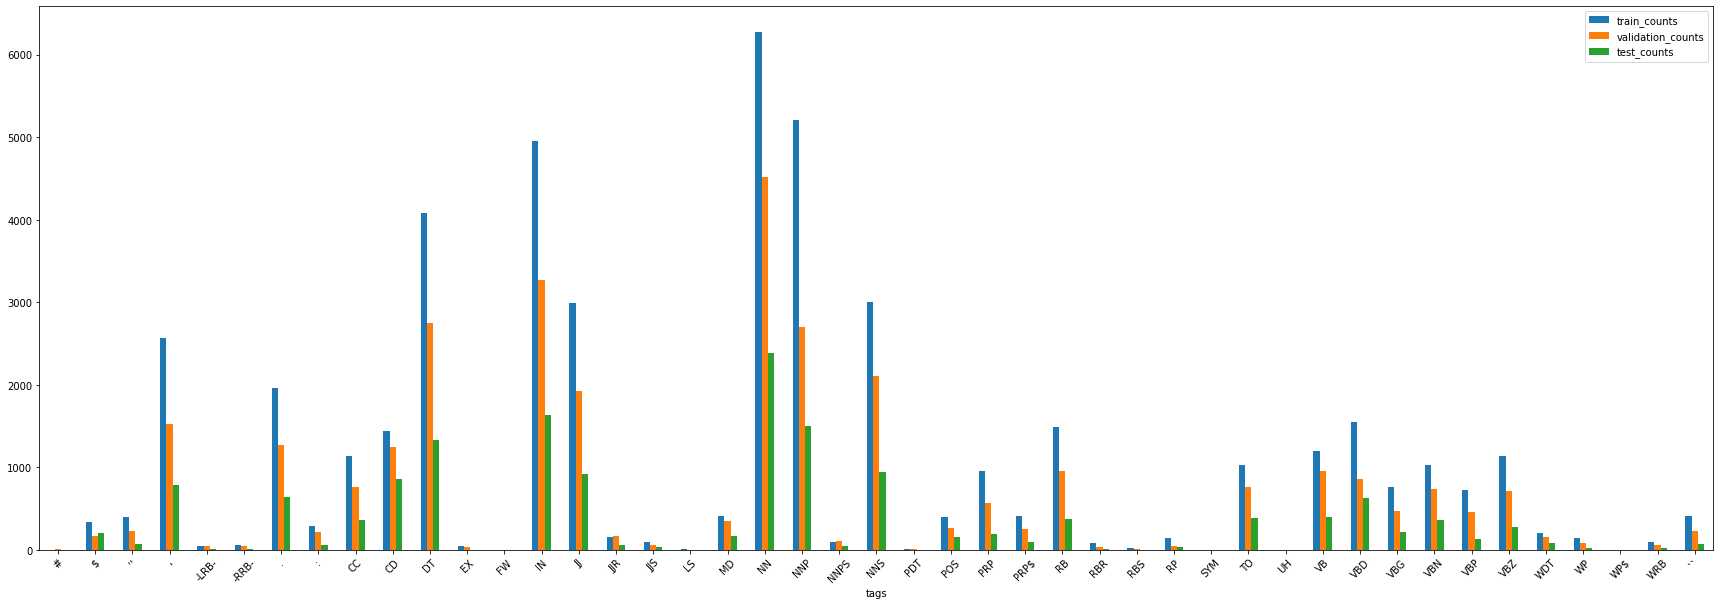

In [10]:
tags_all.plot.bar("tags", rot=45, figsize=(30, 10))
plt.show()

# Model preparation

In [11]:
@dataclass
class ModelConfiguration:
    EMBEDDING_DIM = 300
    MAX_SEQUENCE = 128
    VOCABULARY_SIZE = 15000
    EPOCHS = 50

model_conf = ModelConfiguration()

## Dataframe to dataset

In [12]:
def df_to_dataset(df: pd.DataFrame, batch_size: int = 32) -> tf.data.Dataset:
    df = df.copy()
    return tf.data.Dataset.from_tensor_slices((df["text"], df["tags"])).batch(
        batch_size
    )


raw_all_ds = df_to_dataset(pd.concat([df_train, df_val, df_test]), 512)

## Tokenization and encoding

### Tokenization

In [13]:
class TokenizeFeatures:
    vocab_size: int
    max_sequence: int
    layer: keras.layers.TextVectorization

    def __init__(
        self, dataset: tf.data.Dataset, vocab_size: int = 50000, max_sequence: int = 64
    ):
        self.vocab_size = vocab_size
        self.max_sequence = max_sequence

        self.layer = keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode="int",
            standardize="lower",
            output_sequence_length=self.max_sequence,
        )

        features_ds = dataset.map(lambda x, _: x)
        features_ds = features_ds.map(
            lambda x: tf.strings.split(x, sep=" ").to_tensor()
        )
        features_ds = features_ds.map(lambda x: tf.expand_dims(x, -1))

        self.layer.adapt(features_ds)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        return dataset.map(lambda x, y: (self.layer(x), y))

    def get_vocabulary(self) -> typing.List[str]:
        return self.layer.get_vocabulary()


tokenize_features = TokenizeFeatures(
    raw_all_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE
)

### Encode of labels

In [14]:
class EncodeLabels:
    max_sequence: int
    layer: keras.layers.StringLookup

    def __init__(self, dataset: tf.data.Dataset, max_sequence: int = 50000):
        self.max_sequence = max_sequence
        self.layer = keras.layers.StringLookup(output_mode="int")

        label_ds = dataset.map(lambda _, y: y)
        label_ds = label_ds.map(lambda y: tf.strings.split(y, sep=" ").to_tensor())
        label_ds = label_ds.map(lambda y: y[..., : self.max_sequence])
        label_ds = label_ds.map(
            lambda y: tf.concat(
                [y, tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")],
                -1,
            )
        )

        self.layer.adapt(label_ds)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        ds = dataset.map(lambda x, y: (x, tf.strings.split(y, sep=" ").to_tensor()))
        ds = ds.map(lambda x, y: (x, y[..., : self.max_sequence]))
        ds = ds.map(
            lambda x, y: (
                x,
                tf.concat(
                    [
                        y,
                        tf.fill(
                            (tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), ""
                        ),
                    ],
                    -1,
                ),
            )
        )
        ds = ds.map(lambda x, y: (x, self.layer(y)))
        return ds

    def get_vocabulary(self) -> typing.List[str]:
        return self.layer.get_vocabulary()

    def get_vocabulary_size(self) -> int:
        return self.layer.vocabulary_size()


encode_labels = EncodeLabels(raw_all_ds, model_conf.MAX_SEQUENCE)

### Decode of labels (use after inference)

In [15]:
class DecodeLabels:
    layer: keras.layers.StringLookup

    def __init__(self, vocabulary: typing.List[str]):
        self.layer = keras.layers.StringLookup(
            output_mode="int", vocabulary=vocabulary, invert=True
        )

    def __call__(self, ds: np.ndarray, predict=True) -> np.ndarray:
        if predict:
            ds = tf.math.argmax(ds, axis=-1)
        ds = self.layer(ds).numpy()
        # ds = tf.strings.reduce_join(ds, axis=-1, separator=" ")
        # ds = tf.strings.strip(ds)
        return ds.astype(str)


decode_labels = DecodeLabels(encode_labels.get_vocabulary())

## Encode and tokenize datasets

In [16]:
def prepare_data(df: pd.DataFrame, batch_size: int):
    ds = df_to_dataset(df, batch_size)
    ds = encode_labels(ds)
    return tokenize_features(ds).prefetch(tf.data.AUTOTUNE)


train_ds = prepare_data(df_train, 64)
val_ds = prepare_data(df_val, 512)
test_ds = prepare_data(df_test, 512)

## Embedding layer

In [17]:
!wget -q https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip -qq glove.6B.zip

### Get GloVe vocabulary

In [18]:
def load_glove_embedding(glove_file: str) -> typing.Dict[str, np.ndarray]:
    embeddings_index = {}

    with open(glove_file, encoding="utf-8") as f:
        file_content = f.readlines()

    for line in tqdm.tqdm(file_content, desc=f"Loading GloVe"):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs
    return embeddings_index


glove_file = f"glove.6B.{model_conf.EMBEDDING_DIM}d.txt"
embeddings_index = load_glove_embedding(glove_file)

print(f"Found {len(embeddings_index)} word vectors.")

Loading GloVe: 100%|██████████| 400001/400001 [00:29<00:00, 13735.09it/s]


Found 400001 word vectors.


### Handling of OOV terms

In [19]:
def set_reproducibility(seed: int) -> np.random.Generator:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    return np.random.default_rng(seed)

rng = set_reproducibility(42)

In [20]:
def load_model_embedding(
    vocabulary: typing.List[str],
    embeddings_index: typing.Dict[str, np.ndarray],
    embedding_dim: int,
    rng: np.random.Generator,
) -> np.ndarray:
    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

    for i, word in enumerate(vocabulary):
        """If the embedding can be found on V1, we take that, otherwise
        it's an OOV word and therefore we randomly generate an embedding for it"""
        embedding_vector = embeddings_index.get(word, rng.random((embedding_dim,)))
        assert embedding_vector.size == embedding_dim
        embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_matrix = load_model_embedding(
    tokenize_features.get_vocabulary(), embeddings_index, model_conf.EMBEDDING_DIM, rng
)
print(f"Converted {embedding_matrix.shape[0]} words")

Converted 10949 words


# Models

In [21]:
NUM_CLASSES = encode_labels.get_vocabulary_size()
print(f"Number of classes is: {NUM_CLASSES}")

histories = dict()

Number of classes is: 47


In [22]:
# x = keras.layers.SpatialDropout1D(0.3)(embedded)
# x = keras.layers.Dropout(0.2)(x)
# lstm = keras.layers.LSTM(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(0.02))

## Baseline model

Input -> Embedding -> BiLSTM -> Dense

In [23]:
def create_baseline_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    lstm = keras.layers.LSTM(128, return_sequences=True)
    x = keras.layers.Bidirectional(lstm)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


baseline_model = create_baseline_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          3284700   
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128, 47)           12079     
                                                                 
Total params: 3,736,075
Trainable params: 451,375
Non-trainable params: 3,284,700
_________________________________________________________________


In [24]:
histories["baseline"] = baseline_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 9s 49ms/step - loss: 0.8063 - accuracy: 0.8059 - val_loss: 0.5527 - val_accuracy: 0.8627
Epoch 2/50
31/31 [==============================] - 1s 23ms/step - loss: 0.5094 - accuracy: 0.8740 - val_loss: 0.4701 - val_accuracy: 0.8868
Epoch 3/50
31/31 [==============================] - 1s 22ms/step - loss: 0.4255 - accuracy: 0.8970 - val_loss: 0.3822 - val_accuracy: 0.9063
Epoch 4/50
31/31 [==============================] - 1s 22ms/step - loss: 0.3385 - accuracy: 0.9146 - val_loss: 0.3040 - val_accuracy: 0.9224
Epoch 5/50
31/31 [==============================] - 1s 22ms/step - loss: 0.2696 - accuracy: 0.9314 - val_loss: 0.2490 - val_accuracy: 0.9366
Epoch 6/50
31/31 [==============================] - 1s 22ms/step - loss: 0.2219 - accuracy: 0.9446 - val_loss: 0.2109 - val_accuracy: 0.9477
Epoch 7/50
31/31 [==============================] - 1s 23ms/step - loss: 0.1885 - accuracy: 0.9539 - val_loss: 0.1838 - val_accuracy: 0.9542
Epoch 8/50
31

## Model with a Gated Recurrent Units (GRU) Layer

Input -> Embedding -> BiGRU -> Dense

In [25]:
def create_gru_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    gru = keras.layers.GRU(128, return_sequences=True)
    x = keras.layers.Bidirectional(gru)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


gru_model = create_gru_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
gru_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 300)          3284700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 256)         330240    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 128, 47)           12079     
                                                                 
Total params: 3,627,019
Trainable params: 342,319
Non-trainable params: 3,284,700
_________________________________________________________________


In [26]:
histories["gru"] = gru_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 4s 45ms/step - loss: 0.7629 - accuracy: 0.8167 - val_loss: 0.5027 - val_accuracy: 0.8780
Epoch 2/50
31/31 [==============================] - 1s 25ms/step - loss: 0.4365 - accuracy: 0.8958 - val_loss: 0.3753 - val_accuracy: 0.9097
Epoch 3/50
31/31 [==============================] - 1s 20ms/step - loss: 0.3211 - accuracy: 0.9203 - val_loss: 0.2810 - val_accuracy: 0.9295
Epoch 4/50
31/31 [==============================] - 1s 21ms/step - loss: 0.2428 - accuracy: 0.9393 - val_loss: 0.2215 - val_accuracy: 0.9438
Epoch 5/50
31/31 [==============================] - 1s 20ms/step - loss: 0.1934 - accuracy: 0.9515 - val_loss: 0.1838 - val_accuracy: 0.9528
Epoch 6/50
31/31 [==============================] - 1s 21ms/step - loss: 0.1616 - accuracy: 0.9590 - val_loss: 0.1589 - val_accuracy: 0.9578
Epoch 7/50
31/31 [==============================] - 1s 21ms/step - loss: 0.1397 - accuracy: 0.9636 - val_loss: 0.1412 - val_accuracy: 0.9623
Epoch 8/50
31

## Model with two Bidirectional Long Short-Term Memory (LSTM) Layers

Input -> Embedding -> BiLSTM -> BiLSTM -> Dense

In [27]:
def create_dual_lstm_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    for _ in range(2):
        lstm = keras.layers.LSTM(128, return_sequences=True)
        x = keras.layers.Bidirectional(lstm)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


dual_lstm_model = create_dual_lstm_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
dual_lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 300)          3284700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128, 47)           12079     
                                                                 
Total params: 4,130,315
Trainable params: 845,615
Non-train

In [28]:
histories["dual_lstm"] = dual_lstm_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 7s 81ms/step - loss: 0.8031 - accuracy: 0.8045 - val_loss: 0.5620 - val_accuracy: 0.8420
Epoch 2/50
31/31 [==============================] - 1s 39ms/step - loss: 0.5393 - accuracy: 0.8476 - val_loss: 0.5248 - val_accuracy: 0.8489
Epoch 3/50
31/31 [==============================] - 1s 39ms/step - loss: 0.4982 - accuracy: 0.8586 - val_loss: 0.4741 - val_accuracy: 0.8694
Epoch 4/50
31/31 [==============================] - 1s 39ms/step - loss: 0.4290 - accuracy: 0.8846 - val_loss: 0.3867 - val_accuracy: 0.8961
Epoch 5/50
31/31 [==============================] - 1s 41ms/step - loss: 0.3310 - accuracy: 0.9133 - val_loss: 0.2927 - val_accuracy: 0.9198
Epoch 6/50
31/31 [==============================] - 1s 39ms/step - loss: 0.2499 - accuracy: 0.9337 - val_loss: 0.2284 - val_accuracy: 0.9383
Epoch 7/50
31/31 [==============================] - 1s 39ms/step - loss: 0.1972 - accuracy: 0.9482 - val_loss: 0.1878 - val_accuracy: 0.9499
Epoch 8/50
31

## Model with an additional Dense Layer

Input -> Embedding -> BiLSTM -> Dense -> Dense

In [29]:
def create_dual_dense_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    lstm = keras.layers.LSTM(128, return_sequences=True)
    x = keras.layers.Bidirectional(lstm)(x)

    x = keras.layers.TimeDistributed(keras.layers.Dense(num_classes, activation="relu"))(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


dual_dense_model = create_dual_dense_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
dual_dense_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 300)          3284700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 256)         439296    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 128, 47)          12079     
 ibuted)                                                         
                                                                 
 dense_4 (Dense)             (None, 128, 47)           2256      
                                                                 
Total params: 3,738,331
Trainable params: 453,631
Non-train

In [30]:
histories["dual_dense"] = dual_dense_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 4s 50ms/step - loss: 1.2733 - accuracy: 0.8027 - val_loss: 0.5969 - val_accuracy: 0.8421
Epoch 2/50
31/31 [==============================] - 1s 23ms/step - loss: 0.5384 - accuracy: 0.8574 - val_loss: 0.4904 - val_accuracy: 0.8744
Epoch 3/50
31/31 [==============================] - 1s 23ms/step - loss: 0.4432 - accuracy: 0.8875 - val_loss: 0.4000 - val_accuracy: 0.8994
Epoch 4/50
31/31 [==============================] - 1s 23ms/step - loss: 0.3521 - accuracy: 0.9084 - val_loss: 0.3140 - val_accuracy: 0.9175
Epoch 5/50
31/31 [==============================] - 1s 23ms/step - loss: 0.2749 - accuracy: 0.9264 - val_loss: 0.2518 - val_accuracy: 0.9307
Epoch 6/50
31/31 [==============================] - 1s 24ms/step - loss: 0.2214 - accuracy: 0.9414 - val_loss: 0.2097 - val_accuracy: 0.9432
Epoch 7/50
31/31 [==============================] - 1s 23ms/step - loss: 0.1846 - accuracy: 0.9515 - val_loss: 0.1805 - val_accuracy: 0.9512
Epoch 8/50
31

# Evaluation

## Training trend analysis

Let's see how the training of the networks went. 

This is useful in order to determine whether the networks overfitted or not. We could have potentially set up a so-called "callback" and, in particular, an "EarlyStopping" callback, to make sure that the training stops as soon as the chosen metric in the chosen set stops improving (up to a certain tolerance) for a certain number of epochs, but training on this small dataset does not take a lot of time anyway.

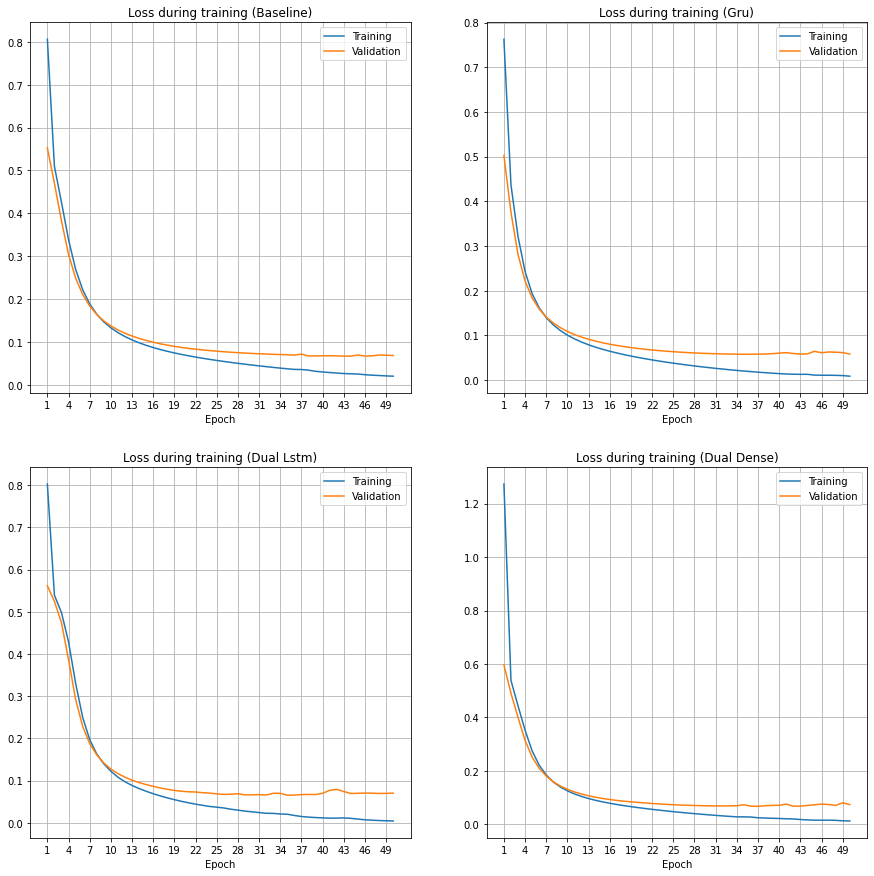

In [31]:
def display_histories(histories: typing.Dict[str, keras.callbacks.History]):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    faxs = axs.ravel()

    for i, (name, history) in enumerate(histories.items()):
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]

        # Visualize the behavior of the loss
        x_values = np.arange(1, len(train_loss)+1)
        faxs[i].plot(x_values, train_loss)
        faxs[i].plot(x_values, val_loss)
        faxs[i].set_xticks(np.arange(1, len(train_loss)+1, step=3))

        faxs[i].grid()
        faxs[i].set_title(f"Loss during training ({name.replace('_', ' ').title()})")
        faxs[i].set_xlabel("Epoch")
        faxs[i].legend(["Training", "Validation"])
    fig.show()


display_histories(histories)

We're very close to the best-case scenario. The graphs allow us to determine that the networks have not overfitted and, instead, learned pretty well how to generalize. This also suggests that we could try to increase the number of epochs in order to obtain even better results.

## Metrics

In [32]:
def decode_true_labels(
    ds: tf.data.Dataset,
    decode_labels: DecodeLabels,
    punctuations: typing.Optional[str] = None,
):
    y_true = decode_labels(np.concatenate([y for _, y in ds], axis=0), predict=False)

    if punctuations is not None:
        df_idx = pd.DataFrame(y_true).apply(lambda x: ~x.str.fullmatch(punctuations))
        idx = df_idx.to_numpy().flatten()
        return y_true.flatten()[idx], idx
    return y_true.flatten(), None

In [33]:
def create_models_dataframe(
    val_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
    models: typing.Dict[str, keras.Model],
    decode_labels: DecodeLabels,
    punctuations: typing.Optional[str] = None,
):
    n_models = len(models.keys())
    ds_dict = {"val": val_ds, "test": test_ds}

    df_dict = dict()
    df_dict["name"] = list(models.keys())

    for ds_name, ds in ds_dict.items():
        # Compute true labels for the dataset
        y_true, idx = decode_true_labels(ds, decode_labels, punctuations)

        # Add results to the dictionary later used to build the DataFrame
        df_dict[f"y_{ds_name}_true"] = np.repeat(
            y_true.reshape(1, -1), n_models, axis=0
        ).tolist()

        y_preds = np.zeros((n_models, y_true.size), dtype=object)
        for i, model in enumerate(models.values()):
            # computing predicted labels for the i-th model
            y_pred = decode_labels(model.predict(ds, verbose=2), predict=True).flatten()
            if idx is not None:
                y_pred = y_pred[idx]
            y_preds[i] = y_pred

        df_dict[f"y_{ds_name}_pred"] = y_preds.tolist()

    for v in df_dict.values():
        assert len(v) == 4
    return pd.DataFrame.from_dict(df_dict, orient="columns")

In [34]:
no_punct_path = os.path.join(os.getcwd(), "df_model_no_punct.pkl")
if os.path.exists(no_punct_path):
    df_no_punct = pd.read_pickle(no_punct_path)
else:
    trained_models = {
        "Baseline": baseline_model,
        "GRU": gru_model,
        "Dual LSTM": dual_lstm_model,
        "Dual Dense": dual_dense_model,
    }
    df_no_punct = create_models_dataframe(
        val_ds, test_ds, trained_models, decode_labels, data_loader.PUNCTUATIONS
    )
    df_no_punct.to_pickle(no_punct_path)

df_no_punct.head()

3/3 - 1s - 808ms/epoch - 269ms/step
3/3 - 1s - 664ms/epoch - 221ms/step
3/3 - 2s - 2s/epoch - 556ms/step
3/3 - 1s - 1s/epoch - 347ms/step
2/2 - 0s - 102ms/epoch - 51ms/step
2/2 - 0s - 89ms/epoch - 45ms/step
2/2 - 0s - 136ms/epoch - 68ms/step
2/2 - 0s - 108ms/epoch - 54ms/step


,name,y_val_true,y_val_pred,y_test_true,y_test_pred
0,Baseline,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ..."
1,GRU,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, NN, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ..."
2,Dual LSTM,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ..."
3,Dual Dense,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, NN, NN, VBD, JJ, NN, IN, DT, NN, IN, JJR,...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ...","[NNP, NNP, NNP, NNP, NNP, NNP, VBD, PRP, VBD, ..."


### Classification report

Checking whether the results on the test set are coherent with the results on the validation set.

At first glance, it could look strange the fact that, even though we excluded the punctuation, some remnants of them can be found in the classification reports above. 

The reason is the following: punctuation has indeed been removed, however, we didn't prevent the model from predicting a punctuation tag (as this would require either changing the model or artificially manipulate the output of the network). Since the model can, sometimes, wrongfully predict a non-punctuation tag as punctuation tag, some rows related to them may occur in the classification report. 

We're sure, though, that the punctuation tags have been removed from the true labels because the support corresponding to punctuation tags is always 0.

In [35]:
def compute_classification_report(y: pd.Series) -> pd.Series:
    print(f"Classification report for the {y['name']} model")
    print("VALIDATION")
    print(classification_report(y["y_val_true"], y["y_val_pred"], zero_division=0))
    print(75 * "-")
    print("TEST")
    print(classification_report(y["y_test_true"], y["y_test_pred"], zero_division=0))
    print(75 * "=")

    cp_val = classification_report(
        y["y_val_true"], y["y_val_pred"], zero_division=0, output_dict=True
    )
    cp_test = classification_report(
        y["y_test_true"], y["y_test_pred"], zero_division=0, output_dict=True
    )
    return pd.Series(
        data={
            "classification_report_val": cp_val,
            "classification_report_test": cp_test,
        }
    )


df_cr_no_punct = df_no_punct.apply(
    lambda x: compute_classification_report(x), axis=1
).rename(index=df_no_punct["name"])

assert isinstance(df_cr_no_punct, pd.DataFrame)

Classification report for the Baseline model
VALIDATION
              precision    recall  f1-score   support

                   1.00      1.00      1.00    135089
           #       0.00      0.00      0.00        15
           $       1.00      1.00      1.00       173
           .       0.00      0.00      0.00         0
          CC       0.99      0.98      0.99       758
          CD       0.95      0.94      0.94      1249
          DT       0.99      0.99      0.99      2754
          EX       0.94      1.00      0.97        34
          FW       0.00      0.00      0.00         2
          IN       0.97      0.96      0.96      3275
          JJ       0.74      0.76      0.75      1924
         JJR       0.84      0.81      0.82       165
         JJS       0.85      0.67      0.75        58
          LS       1.00      0.33      0.50         3
          MD       0.99      0.97      0.98       347
          NN       0.79      0.89      0.84      4513
         NNP       0.89  

### Confusion matrix

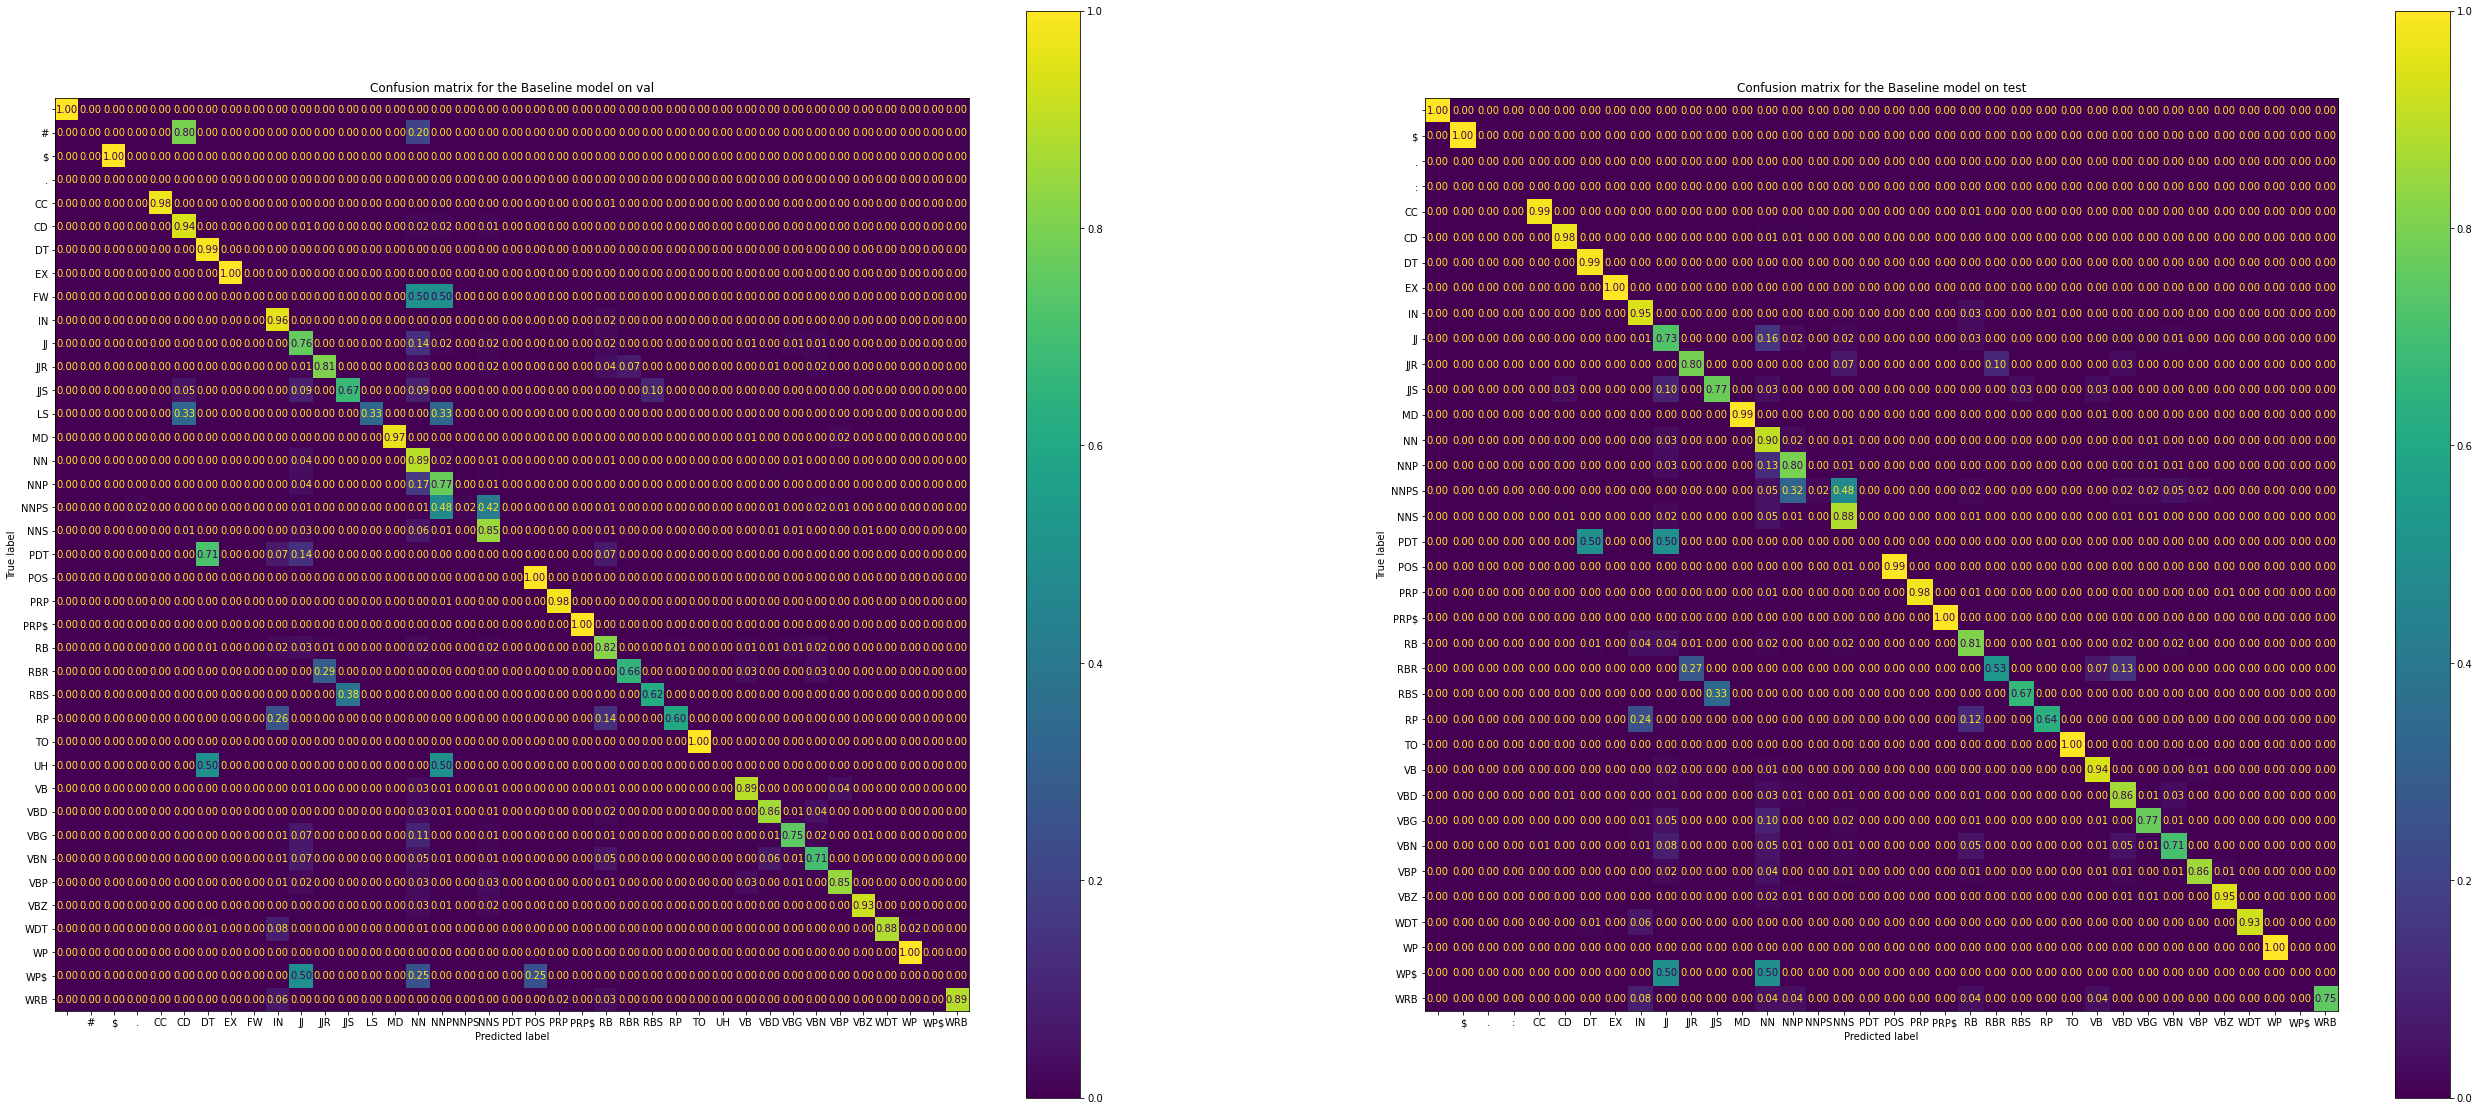

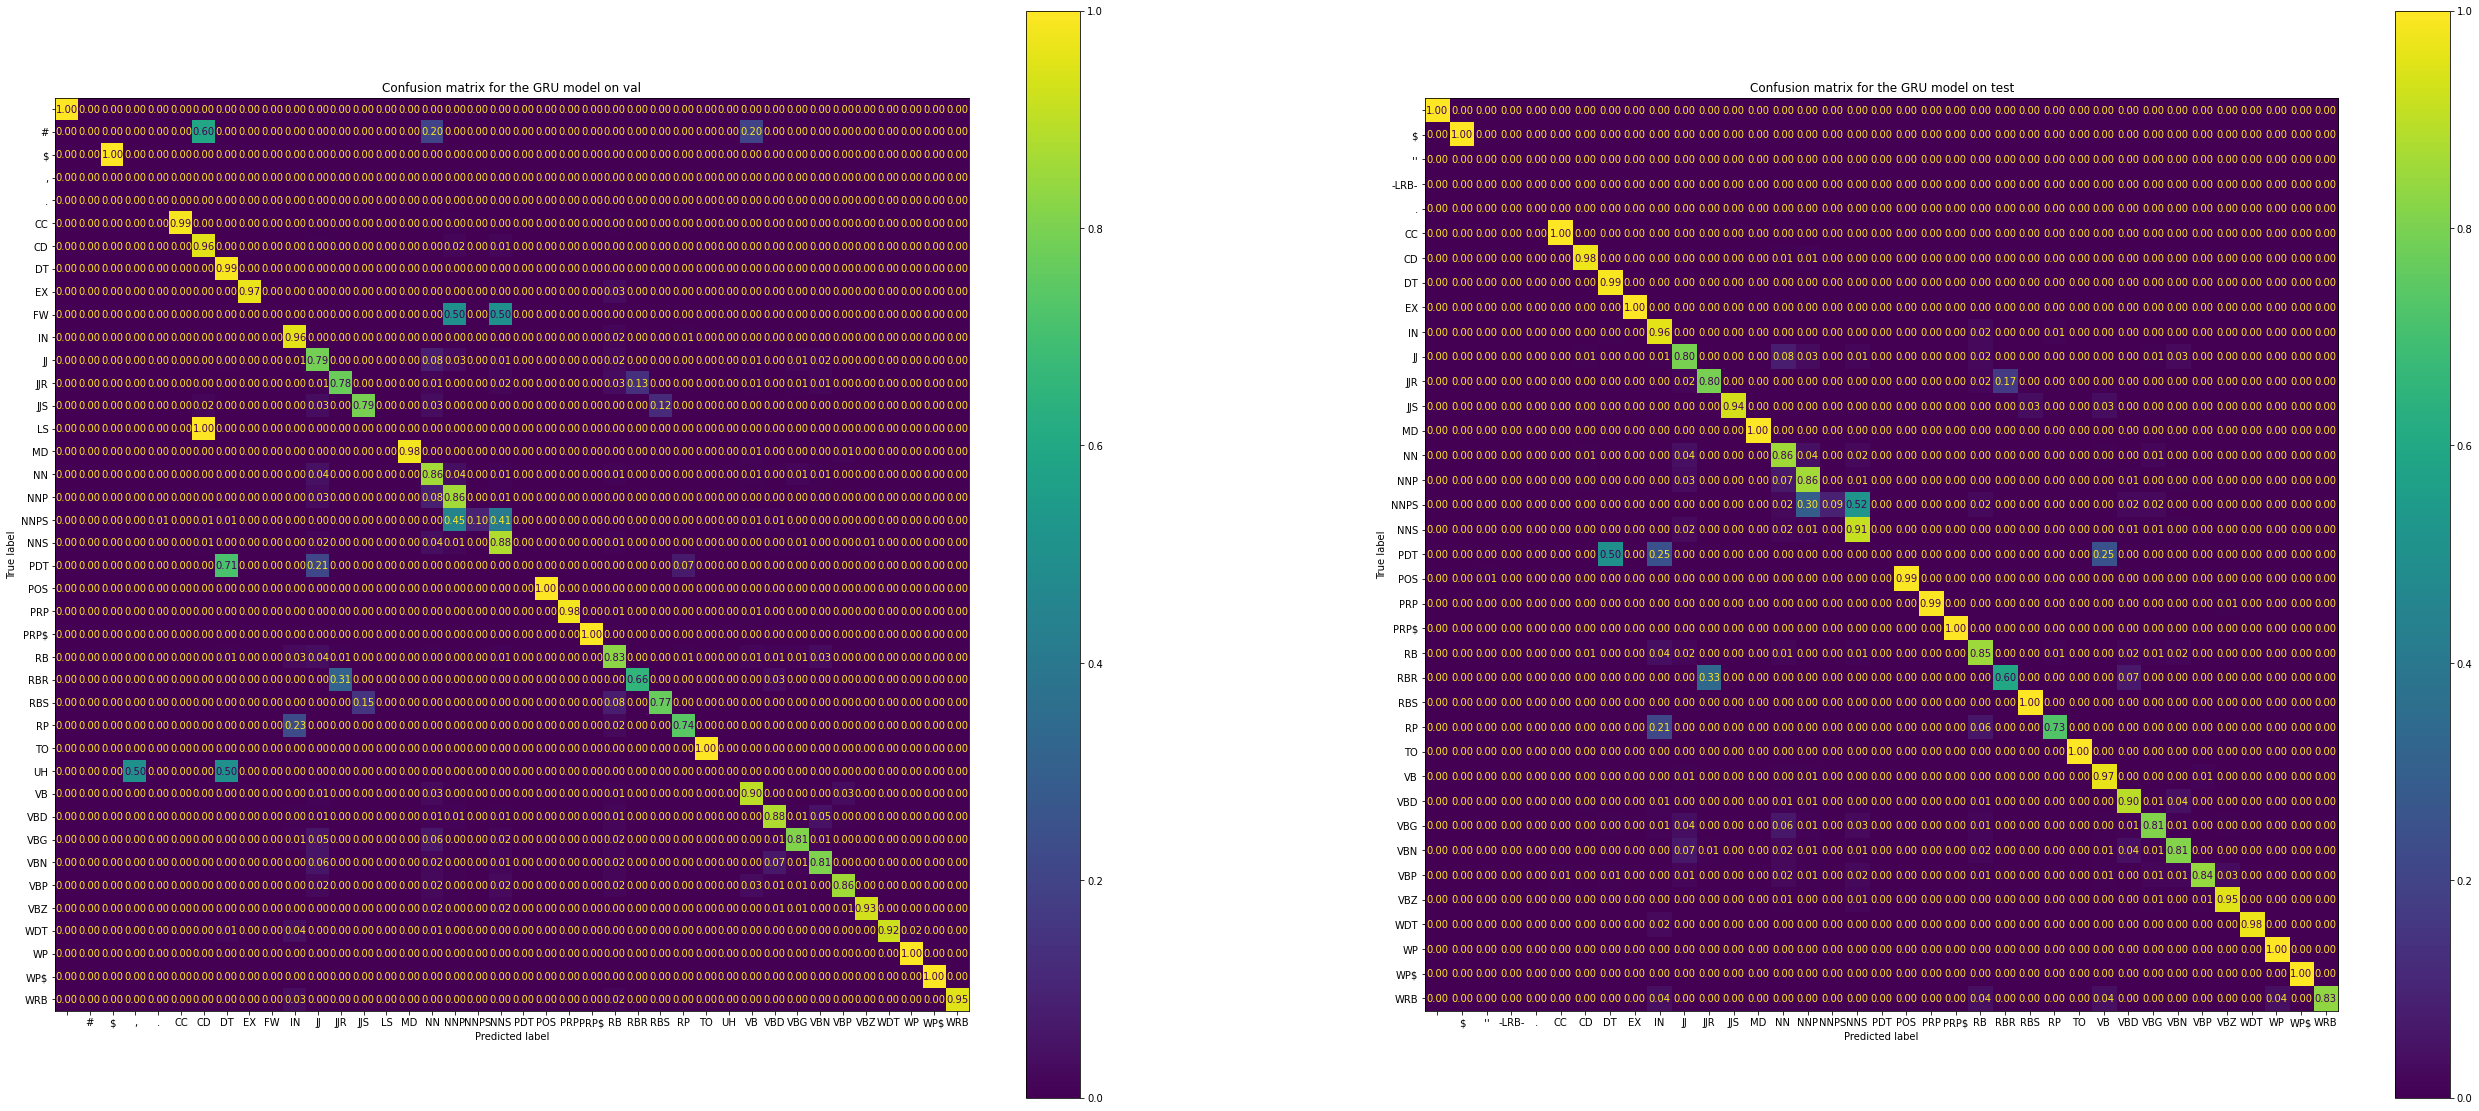

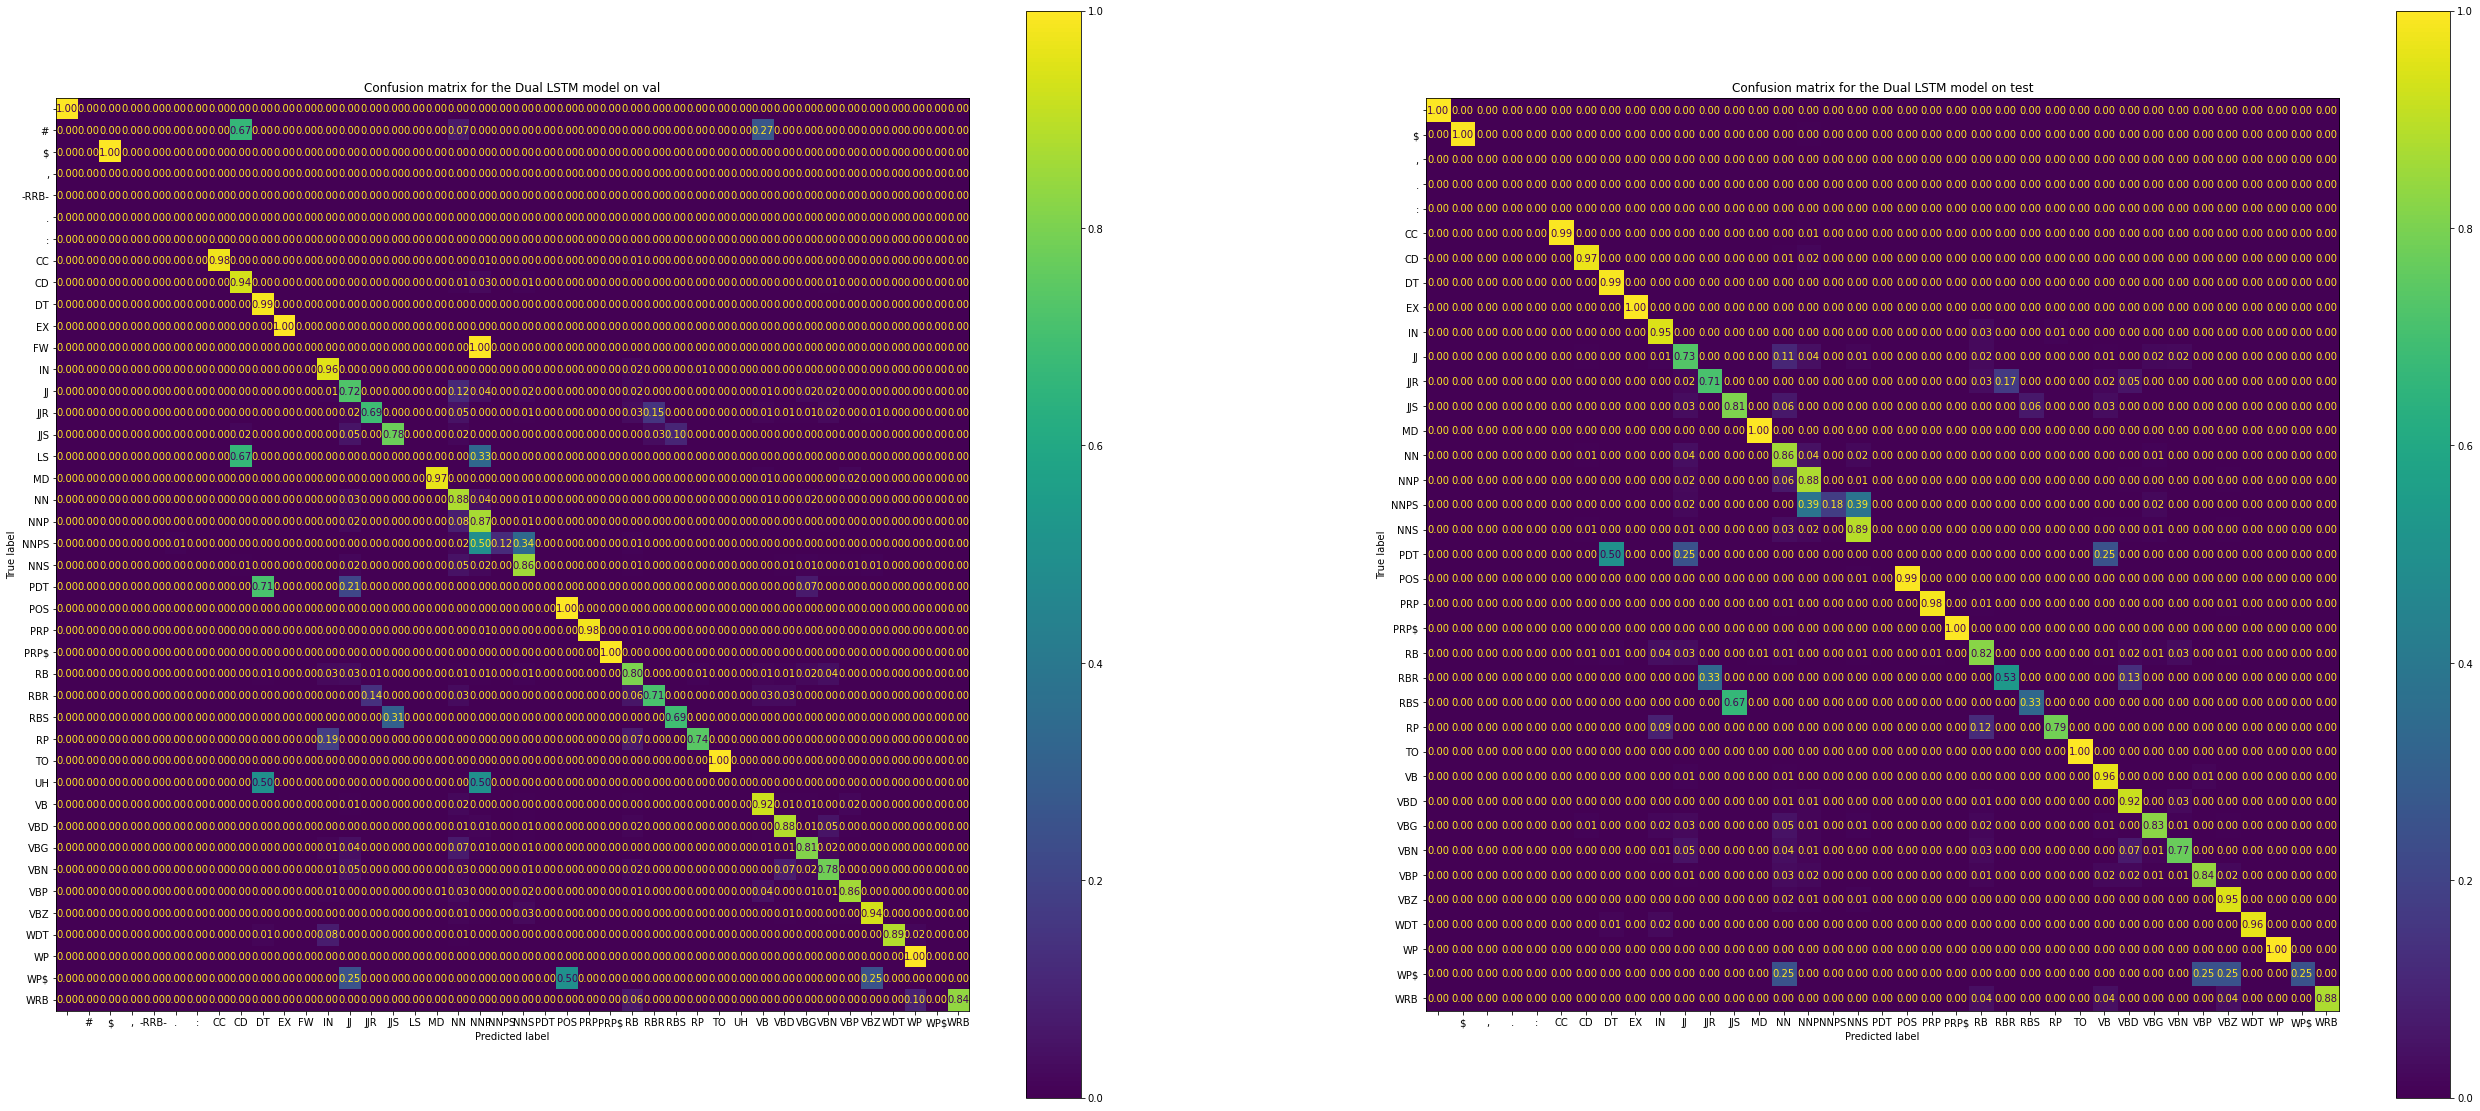

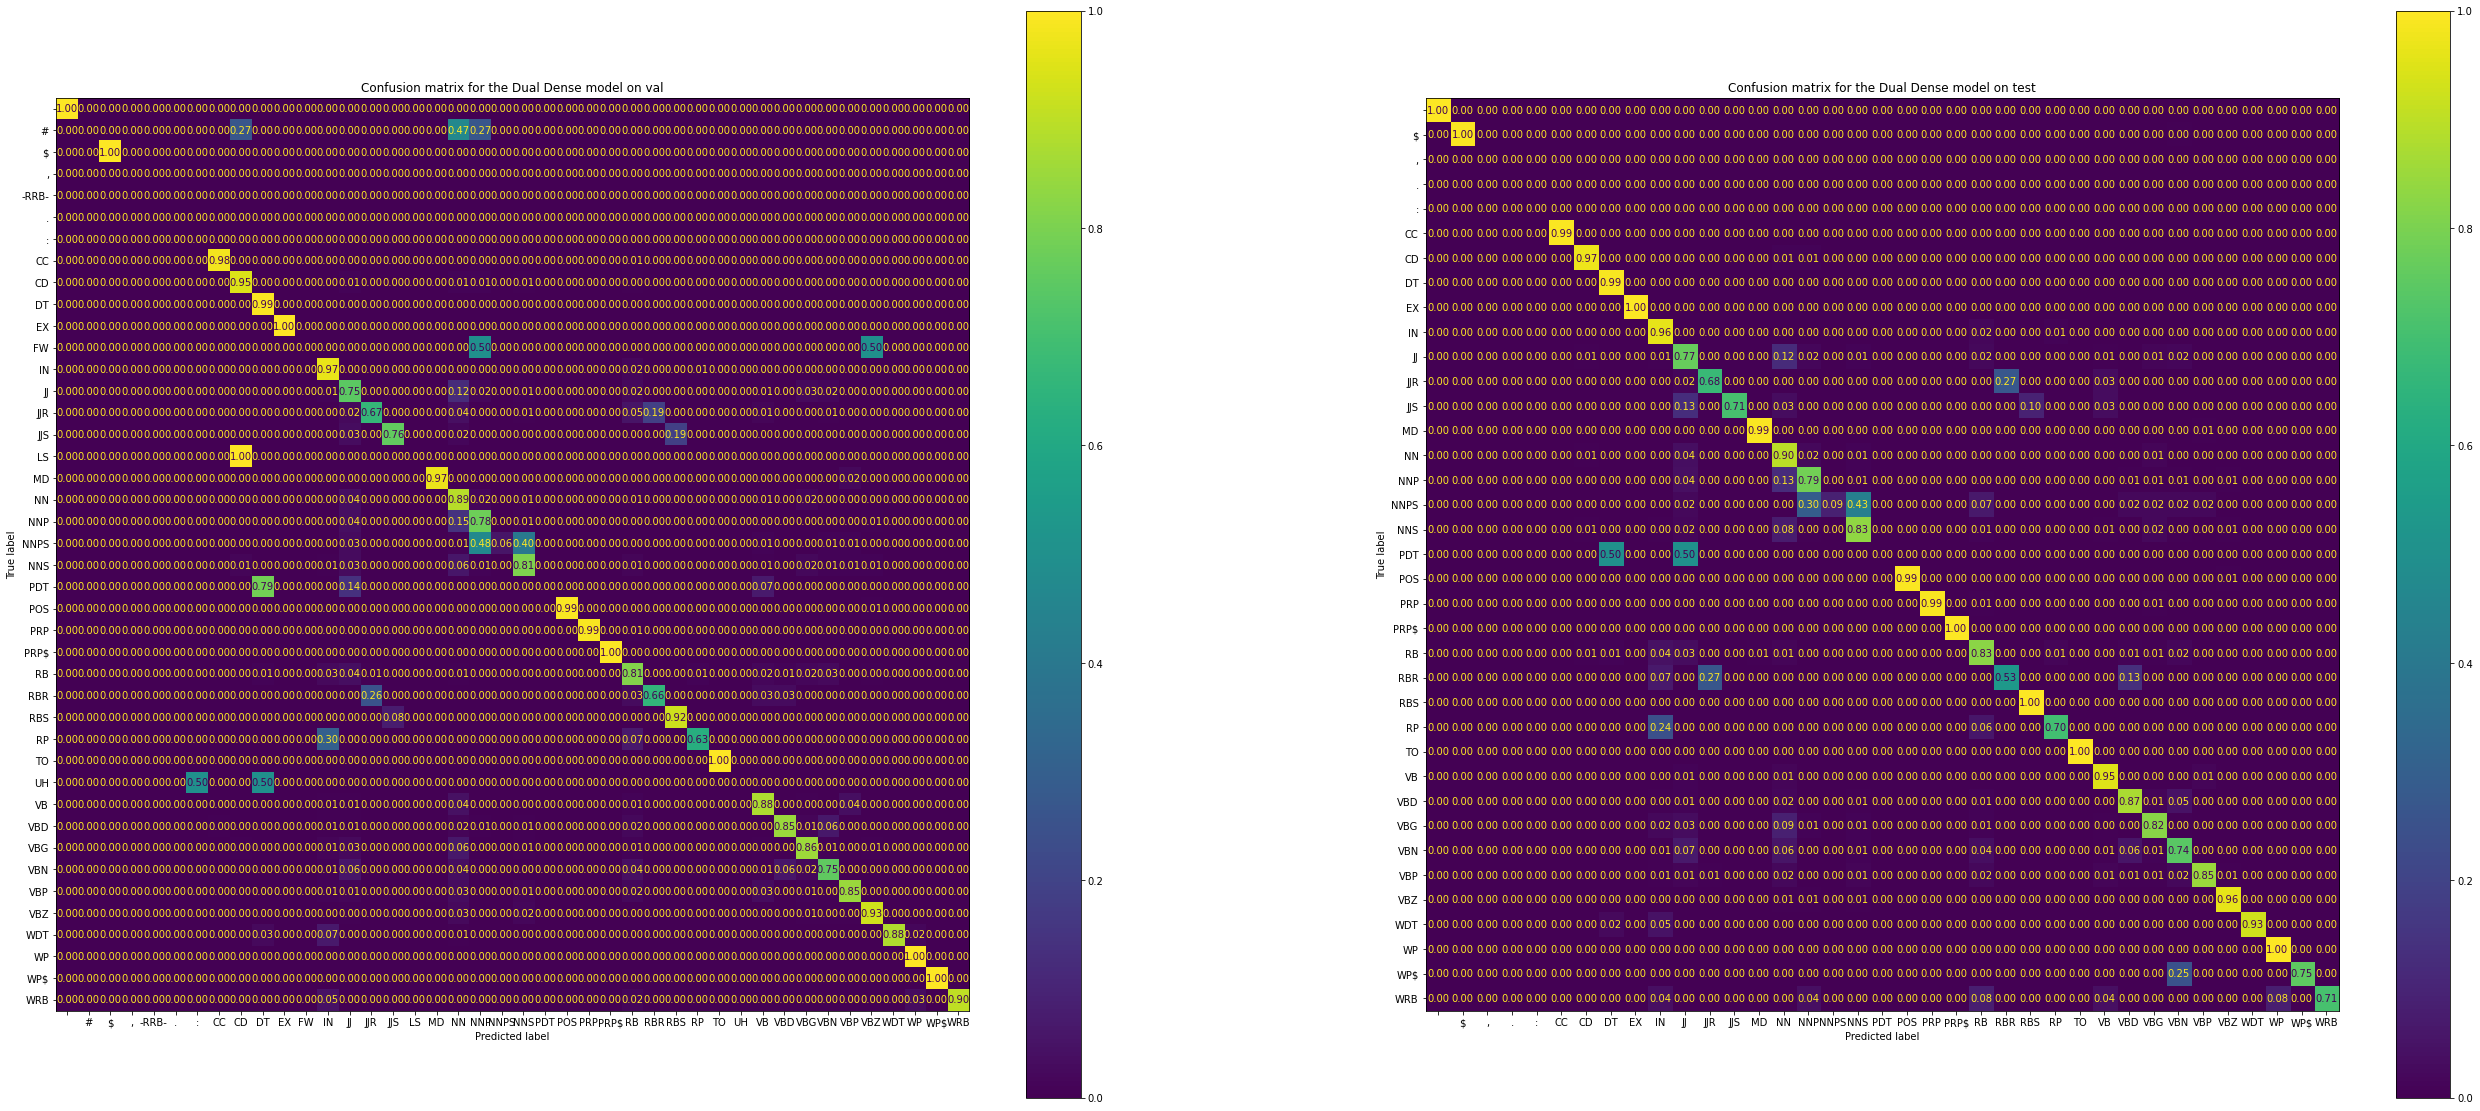

In [36]:
def plot_confusion_matrix(y: pd.Series):
    fig, axs = plt.subplots(1, 2, figsize=(45, 20))
    faxs = axs.ravel()

    for i, column_name in enumerate(["val", "test"]):
        # Validation set
        y_true = y[f"y_{column_name}_true"]
        y_pred = y[f"y_{column_name}_pred"]

        labels = np.unique(np.concatenate([y_true, y_pred]))
        disp = ConfusionMatrixDisplay(
            confusion_matrix(y_true, y_pred, normalize="true"),
            display_labels=labels,
        )
        disp.plot(ax=faxs[i], values_format=".2f")

        faxs[i].set_title(
            f"Confusion matrix for the {y['name']} model on {column_name}"
        )
    fig.show()


_ = df_no_punct.apply(lambda x: plot_confusion_matrix(x), axis=1)

### Histograms of macro averages of precision, recall and f1-score.

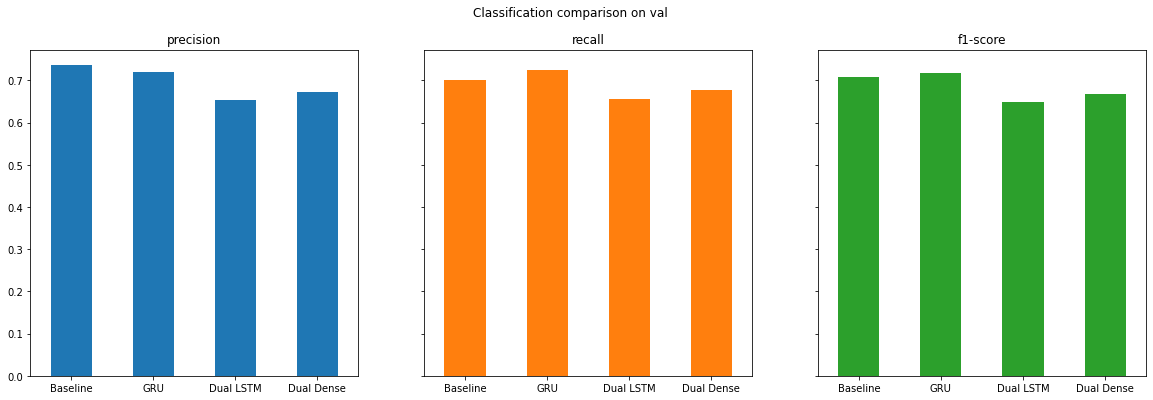

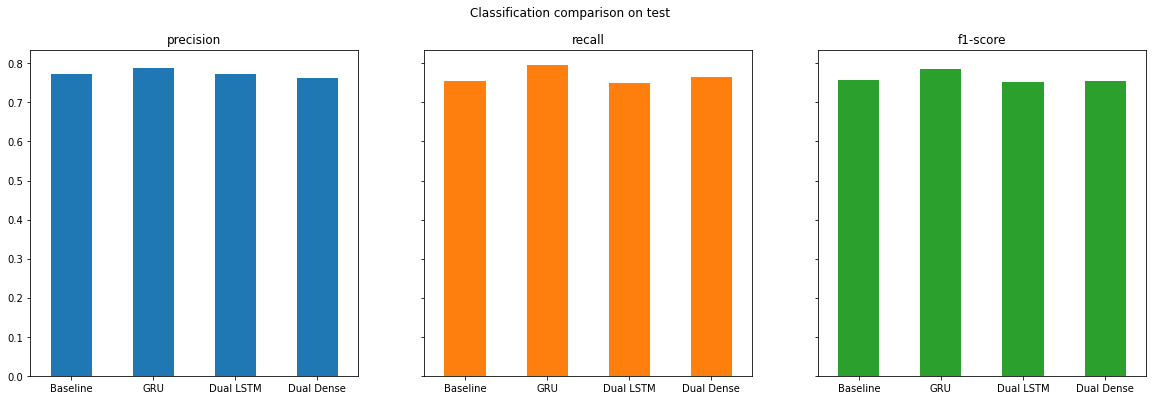

In [37]:
def plot_histogram(df: pd.DataFrame, names: typing.List[str]):
    for name in names:
        df_histogram = df.apply(
            lambda x: pd.Series({**x[f"classification_report_{name}"]["macro avg"]}),
            axis=1,
        )

        df_histogram.plot.bar(
            y=["precision", "recall", "f1-score"],
            legend=False,
            subplots=True,
            sharey=True,
            layout=(1, 3),
            figsize=(20, 6),
            rot=0,
            xlabel="",
            title=f"Classification comparison on {name}",
        )


plot_histogram(df_cr_no_punct, ["val", "test"])

Metrics that are usually computed like the R2, the MSE and the MAE are not useful in this situation: as a matter of fact, tags are assigned a number just for convenience purposes, but this does not mean that there is a "distance" between tags. 

The classic metrics like R2, MSE and MAE would implicitly assume that a distance between two tags can be computed, and that this would be equal to the absolute difference of the numerical representations of the tags, but this wouldn't make any sense. Suppose that a word should be classified with a tag $T$: the gravity of the error does not change if the word is misclassified with a tag $T' \neq T$, regardless of $T'$ and $T$.

### Bars of macro averages of precision, recall and f1-score among tags

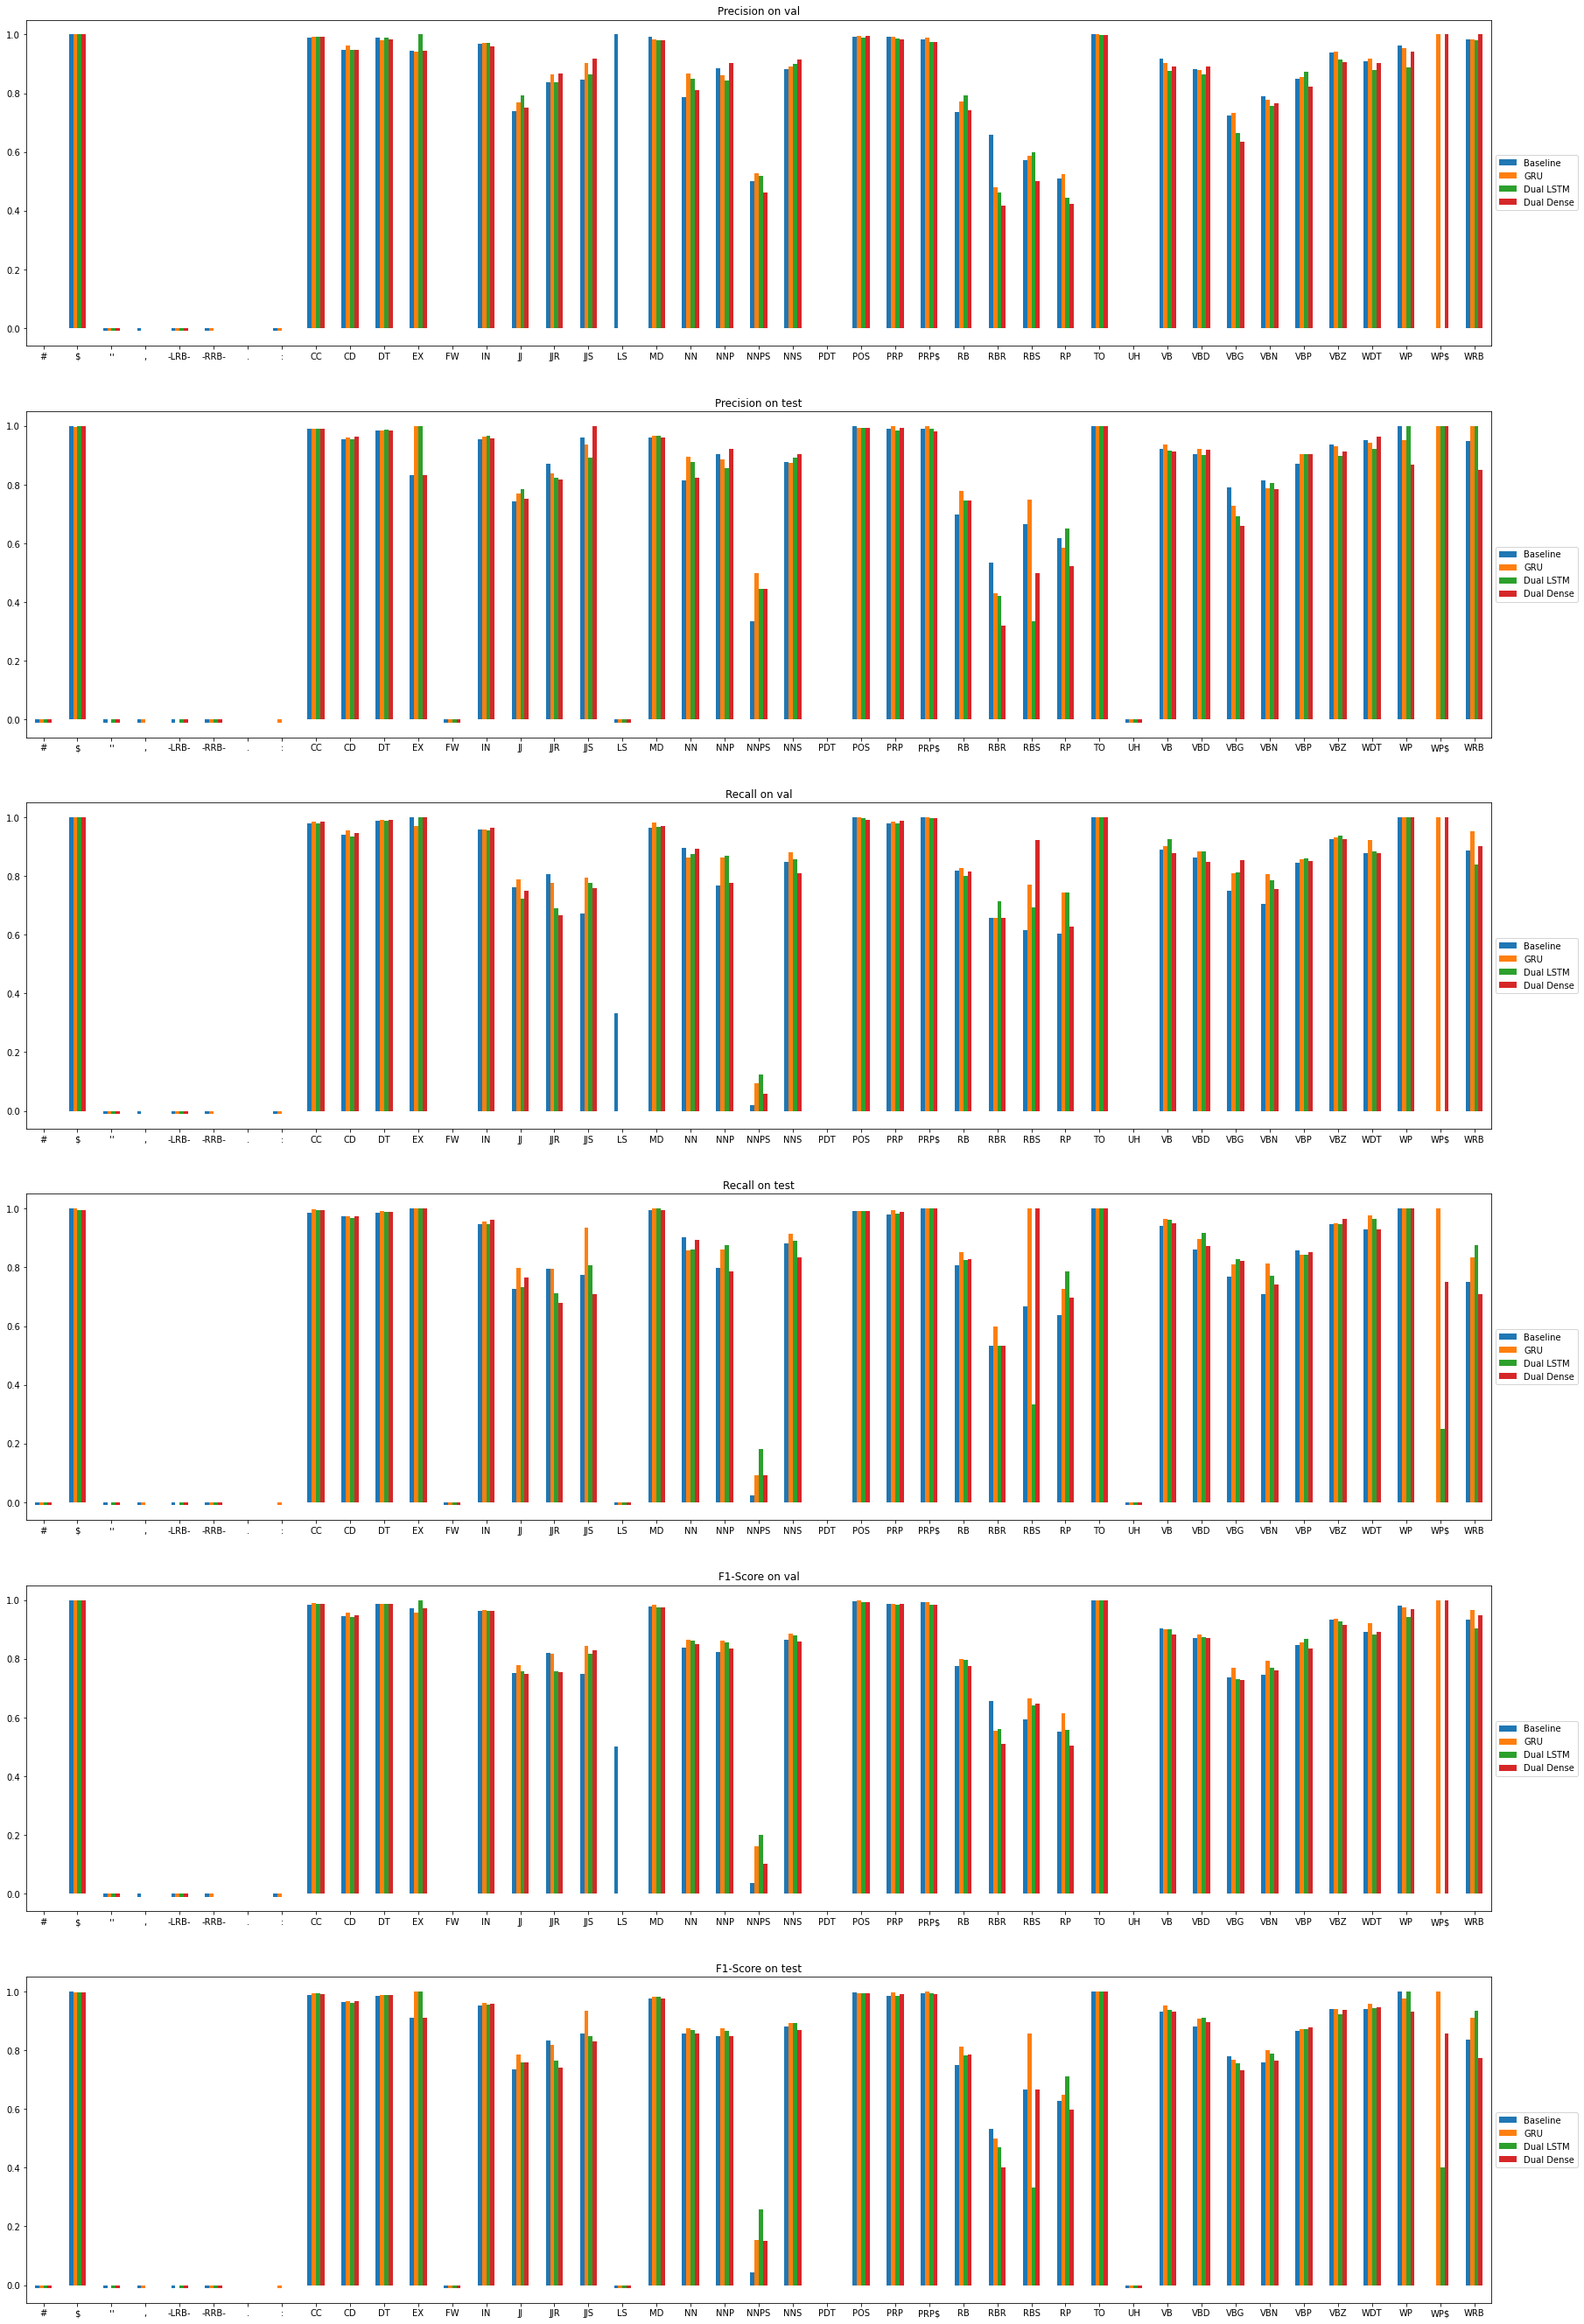

In [38]:
def tags_transformation(ser: pd.Series, name: str, metric: str, all_tags: typing.Set[str]) -> pd.Series:
    drop_columns = ["", "accuracy", "macro avg", "weighted avg"]
    s = pd.Series({**ser[f"classification_report_{name}"]})
    s = s.reindex(sorted(all_tags), axis=1)
    return s.drop(drop_columns).map(lambda x: x[metric], na_action="ignore")


def plot_tags_histograms(df: pd.DataFrame, names: typing.List[str]):
    all_tags = set(df.applymap(lambda x: list(x.keys())).agg(np.concatenate).agg(np.concatenate))
    metrics = ["precision", "recall", "f1-score"]

    total_num = len(metrics) * len(names)
    fig, axs = plt.subplots(total_num, figsize=(30, 8 * total_num))
    faxs = axs.ravel()
    i = 0

    for metric in metrics:
        for name in names:
            df_tmp = df.apply(tags_transformation, axis=1, args=(name, metric, all_tags))
            df_tmp.fillna(-0.01, inplace=True)
            # df_tmp.rename(index=df["name"], inplace=True)

            df_t = df_tmp.transpose()    
            df_t.plot.bar(ax=faxs[i], title=f"{metric.title()} on {name}", legend={"reverse"}, rot=0)
            faxs[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

            i += 1

    fig.show()

plot_tags_histograms(df_cr_no_punct, ["val", "test"])

Small note: the "negative" scores are just symbolic, and are meant to distinguish tags for which a score does not exist from tags whose score is actually 0. This has been done since there is some small discrepancy between the set of predicted tags across models (for example, some predict sometimes the tag corresponding to ":" whereas some others do not at all).

## Error analysis

From the metrics, we can see that the results obtained in the validation set are coherent with the results on the test set. By "coherent", we mean that:

- Whenever a score (e.g. F1 score) is high for a single tag in the test set, the same holds for the same tag in the validation set (when the supports of the given tag are sufficiently close in both sets). This can be easily confirmed by looking at the classification reports.
- The classification capabilities of the models are very similar: we can quickly judge it by comparing the graphical representations of the confusion matrices generated from the performances of the models in the test set and in the validation set (whenever the supports of the given tag is sufficiently close in both sets, which can be seen again in the classification reports).

Since the results are coherent, we can just inspect the results obtained in the test set. We can observe in many ways that a lot of classes are correctly recognized most of the time. We want to inspect and hopefully give an explanation as for why some classes are not.

In [39]:
def print_top_results(
    ser: pd.Series, n_tags: int, reverse = False
):
    name = "test"
    drop_columns = ["", "accuracy", "macro avg", "weighted avg"]
    metric = "f1-score"

    cp = {**ser[f"classification_report_{name}"]}
    metric_tags = [
        (k, round(v["f1-score"], 3)) for k, v in cp.items() if k not in drop_columns
    ]
    metric_tags.sort(key=lambda x: x[1], reverse=reverse)

    print(f"{ser.name}: {metric_tags[:n_tags]}")


print("---Worst classified tags---")
_ = df_cr_no_punct.apply(print_top_results, axis=1, n_tags=10)

print("\n\n---Best classified tags---")
_ = df_cr_no_punct.apply(print_top_results, axis=1, n_tags=10, reverse=True)

---Worst classified tags---
Baseline: [('.', 0.0), (':', 0.0), ('PDT', 0.0), ('WP$', 0.0), ('NNPS', 0.043), ('RBR', 0.533), ('RP', 0.627), ('RBS', 0.667), ('JJ', 0.736), ('RB', 0.748)]
GRU: [("''", 0.0), ('-LRB-', 0.0), ('.', 0.0), ('PDT', 0.0), ('NNPS', 0.154), ('RBR', 0.5), ('RP', 0.649), ('VBG', 0.767), ('JJ', 0.784), ('VBN', 0.8)]
Dual LSTM: [(',', 0.0), ('.', 0.0), (':', 0.0), ('PDT', 0.0), ('NNPS', 0.258), ('RBS', 0.333), ('WP$', 0.4), ('RBR', 0.471), ('RP', 0.712), ('VBG', 0.755)]
Dual Dense: [(',', 0.0), ('.', 0.0), (':', 0.0), ('PDT', 0.0), ('NNPS', 0.151), ('RBR', 0.4), ('RP', 0.597), ('RBS', 0.667), ('VBG', 0.732), ('JJR', 0.741)]


---Best classified tags---
Baseline: [('$', 1.0), ('TO', 1.0), ('WP', 1.0), ('POS', 0.997), ('PRP$', 0.995), ('CC', 0.988), ('DT', 0.986), ('PRP', 0.984), ('MD', 0.976), ('CD', 0.965)]
GRU: [('EX', 1.0), ('PRP$', 1.0), ('TO', 1.0), ('WP$', 1.0), ('$', 0.998), ('PRP', 0.997), ('CC', 0.993), ('POS', 0.993), ('DT', 0.987), ('MD', 0.982)]
Dual LSTM: 

All models appear to behave very similarly even at the level of the tags. Many tags are classified either badly or well by all the models. 

Since the models have different architectures behind, it's reasonable to think that the reason lies before the model itself: the training set. 

We have plotted some histograms about the distribution of the classes. We can use those to look for an explanation as for why some tags are better classified than others. 

Let's compare for example the distribution of the tag "NNPS" (Proper noun, plural), badly classified by every model, and the tag "PRP\$" (Possessive pronoun), which is instead perfectly classified by all the models.

In [40]:
tags_all.head()

,tags,train_counts,validation_counts,test_counts
0,#,1,15,0
1,$,342,173,209
2,'',399,225,70
3,",",2571,1528,787
4,-LRB-,52,50,18


In [41]:
tag1 = "NNPS"
tag2 = "PRP$"

tags_all[(tags_all["tags"] == tag1) | (tags_all["tags"] == tag2)][["tags", "train_counts"]]

,tags,train_counts
21,NNPS,95
26,PRP$,409


On one hand, it certainly explains why all the models perform better in classifying the "PRP\$" tag rather than the "NNPS" tag, but this doesn't entirely capture the complexity of the situation. A hint is given by the fact that there are other tags with many more "examples" that, however, the model is not able to classify as well as "PRP\$". One such example is, trivially, the tag with the maximum number of examples:

In [42]:
tags_all[tags_all["train_counts"] == tags_all["train_counts"].max()][
    ["tags", "train_counts"]
]

,tags,train_counts
19,NN,6270


### Noun, singular or mass

NN is the name of the tag used to classify the following: "Noun, singular or mass".

This could give another hint as for why this tag requires more effort in order to be recognized correctly, even though there are a lot more examples: there are a lot of possible names, whereas the number of possessive pronouns is very limited. 

Clearly, other factors may affect the assigned tag to a certain token: after all, the models are very complex and also take into account the tokens around (usually referred to as "context") and their order in both directions. 

Just to peek at the reason of this apparent discrepancy, rather than considering the total number of examples, we should evaluate the total number of unique examples that can be found both in the training set and in the test set out of the total number unique examples that can be found in the test set. 

A ratio close to 1 should correlate to good performances, and a small set of possible values should push the ratio towards 1 more easily.

In [135]:
def restrict_words(ser: pd.Series, tag: str):
    text_s, text_t = ser["text"].split(" "), ser["tags"].split(" ")
    return np.array(text_s)[np.array(text_t) == tag]

def search_unique_words(df: pd.DataFrame, tag: str):
    return np.unique(df.apply(restrict_words, axis=1, tag=tag).agg(np.concatenate))

tag = "NN"
test_words = search_unique_words(df_test, tag)
train_words = search_unique_words(df_train, tag)
intersect_words = np.intersect1d(test_words, train_words, assume_unique=True)

print(f"Number of unique words tagged as '{tag}' in the test set: {test_words.size}")
print(f"Number of unique words tagged as '{tag}' in the training set: {train_words.size}")
print(f"Number of unique words tagged as '{tag}' can be found in both test set and train set: {intersect_words.size}")
print(f"Therefore, the ratio we're interested in is: {intersect_words.size/test_words.size:.2f}")

Number of unique words tagged as 'NN' in the test set: 818
Number of unique words tagged as 'NN' in the training set: 1805
Number of unique words tagged as 'NN' can be found in both test set and train set: 502
Therefore, the ratio we're interested in is: 0.61


But since the models are way more complex than that and are not limited to memorizing examples and tagging according to it, we can reasonably expect higher performances.

### Possessive pronouns

We can repeat the exact same procedure for the possessive pronouns:

In [136]:
tag = "PRP$"
test_words = search_unique_words(df_test, tag)
train_words = search_unique_words(df_train, tag)
intersect_words = np.intersect1d(test_words, train_words, assume_unique=True)

print(f"Number of unique words tagged as '{tag}' in the test set: {test_words.size}")
print(f"Number of unique words tagged as '{tag}' in the training set: {train_words.size}")
print(f"Number of unique words tagged as '{tag}' can be found in both test set and train set: {intersect_words.size}")
print(f"Therefore, the ratio we're interested in is: {intersect_words.size/test_words.size:.2f}")

Number of unique words tagged as 'PRP$' in the test set: 8
Number of unique words tagged as 'PRP$' in the training set: 13
Number of unique words tagged as 'PRP$' can be found in both test set and train set: 8
Therefore, the ratio we're interested in is: 1.00


Which explains the discrepancy we've observed.

### Removing punctuation

Now, as an extra, we wanted to investigate in which way removing the punctuation influences the results. 

By following the same reasoning done to explain the discrepancy between class frequency and class labeling performances, we can conjecture that, by including the punctuation signs, the scores should improve (because we would now consider more tags that are very likely to be correctly identified). 

In order to confirm our suspicions, we just compute again the metrics that have been computed before, without removing the tags associated with punctuation beforehand.

In [45]:
punct_path = os.path.join(os.getcwd(), "df_model_punct.pkl")
if os.path.exists(punct_path):
    df_punct = pd.read_pickle(punct_path)
else:
    trained_models = {
        "Baseline": baseline_model,
        "GRU": gru_model,
        "Dual LSTM": dual_lstm_model,
        "Dual Dense": dual_dense_model,
    }
    df_punct = create_models_dataframe(val_ds, test_ds, trained_models, decode_labels)
    df_punct.to_pickle(punct_path)

df_punct.head()

3/3 - 0s - 171ms/epoch - 57ms/step
3/3 - 0s - 161ms/epoch - 54ms/step
3/3 - 0s - 260ms/epoch - 87ms/step
3/3 - 0s - 138ms/epoch - 46ms/step
2/2 - 0s - 102ms/epoch - 51ms/step
2/2 - 0s - 92ms/epoch - 46ms/step
2/2 - 0s - 127ms/epoch - 64ms/step
2/2 - 0s - 106ms/epoch - 53ms/step


,name,y_val_true,y_val_pred,y_test_true,y_test_pred
0,Baseline,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
1,GRU,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, NN, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
2,Dual LSTM,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, JJ, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJR...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
3,Dual Dense,"[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...","[DT, NN, NN, VBD, JJ, NN, IN, DT, NN, IN, JJR,...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."


In [51]:
df_cr_punct = df_punct.apply(lambda x: compute_classification_report(x), axis=1).rename(index=df_punct["name"])

assert isinstance(df_cr_punct, pd.DataFrame)

Classification report for the Baseline model
VALIDATION
              precision    recall  f1-score   support

                   1.00      1.00      1.00    135089
           #       0.00      0.00      0.00        15
           $       1.00      1.00      1.00       173
          ''       1.00      1.00      1.00       225
           ,       1.00      1.00      1.00      1528
       -LRB-       1.00      0.98      0.99        50
       -RRB-       1.00      0.98      0.99        53
           .       1.00      1.00      1.00      1277
           :       1.00      1.00      1.00       214
          CC       0.99      0.98      0.98       758
          CD       0.95      0.94      0.94      1249
          DT       0.99      0.99      0.99      2754
          EX       0.94      1.00      0.97        34
          FW       0.00      0.00      0.00         2
          IN       0.97      0.96      0.96      3275
          JJ       0.74      0.76      0.75      1924
         JJR       0.84  

In [117]:
def print_compare_metric(ser: pd.Series, metric: str):
    rename_fun = lambda x: (x, "_".join([metric] + x.rsplit("_", maxsplit=2)[-2:]))
    return ser.apply(lambda x: x['macro avg'][metric]).rename(dict(map(rename_fun, list(ser.index))))

# print_metric([df_cr_punct, ["val", "test"], "f1-score")
df_cr_punct.join(df_cr_no_punct, lsuffix="_punct", rsuffix="_no_punct").apply(print_compare_metric, axis=1, metric="f1-score").head()

,f1-score_val_punct,f1-score_test_punct,f1-score_no_punct,f1-score_no_punct
Baseline,0.768486,0.834471,0.708040,0.758721
GRU,0.792381,0.879958,0.716761,0.786902
Dual LSTM,0.760779,0.847963,0.649938,0.753142
Dual Dense,0.777143,0.848630,0.667196,0.754401
